In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
import io
import time#for recording time 
import sys #for getting size of object
!pip install texttable
from texttable import Texttable

plt.rcParams["figure.figsize"] = (10,10)



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
random.seed(10)

### *Importing files from github for google colab


In [3]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/varicella_prevalance.csv'
V_prevalence_df =pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url4,header=None,engine='python')

### *importing files from pc


# THE GRAPH CONTROL PANEL

In [4]:
N =2000# Number of nodes
setting='work'    #the setting we are evaluating(home,work,school,other)
birth_rate=.03

## 1-Defining Nodes

In [5]:
#defining a dictionary of nodes

group_popularity = dict() #based on consensus year 95
v_prevalence=dict() #based on meta analysis(data is not exact!! update needed!!)contan(age_group,prevalance,lower CL)
nodes_dic=dict() #dictionary of nodes
frequency=dict()


for i, row in population_df.iterrows():
    group_popularity[row[0]]=float(row[1])
    
for i, row in V_prevalence_df.iterrows():
    v_prevalence[row[0]]=[float(row[1]),float(row[2])]
    

#importing data for frequency of contact in each setting for comparison
for i, row in frequency_df.iterrows():
    frequency[row[0]]=dict()
    for i in range(1,6):
        frequency[row[0]][i]=float(row[i])
                    
for i in range(N):#deciding nodes ages
    while True:
        r=random.random()
        t=random.choice(list(group_popularity.keys()))
        if r<=group_popularity[t]:
            nodes_dic[i]={'age':t}
            break


for i in range(N):  #deciding nodes seropositivity
    a=v_prevalence[nodes_dic[i]['age']][0]
    b=v_prevalence[nodes_dic[i]['age']][1]
    r=np.random.random()
    t=np.random.normal(a,(a-b)) 
    if r<=t:
        nodes_dic[i]['infection']=1
    else:
        nodes_dic[i]['infection']=0
        

### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [6]:

# the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'20_24': 153,
 '0_4': 176,
 '10_14': 120,
 '15_19': 123,
 '30_34': 206,
 '50_54': 115,
 '55_59': 77,
 '25_29': 227,
 '5_9': 162,
 '65_69': 47,
 '35_39': 153,
 '40_44': 158,
 '75+': 57,
 '45_49': 122,
 '60_64': 66,
 '70_74': 38}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [7]:
#importing rules from .csv to nested dictionary
rules={}  # rules contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules[location[o]]=temp_1.copy()     

In [8]:
#claculating how many contact a person has with all age groups in the setting
#calculating how many 'connectons' is required for the contacts with specific frequency
rules_sum=dict()
for i in rules.keys():
    rules_sum[i]=dict()
    for j in rules[i].keys():
        t=0
        rules_sum[i][j]={'count_total':0,'count1':0,'count2':0,'count3':0}
        for k in rules[i][j]:
            t+=rules[i][j][k]
    
        rules_sum[i][j]['count_total']=t
        rules_sum[i][j]['count1']=t*frequency[i][1]
        rules_sum[i][j]['count2']=t*frequency[i][2]*(7/1.5)
        rules_sum[i][j]['count3']=t*frequency[i][3]*(30/1.5)
        #number of 'contacts' with random probability
        rules_sum[i][j]['count4']=t*(frequency[i][4]+frequency[i][5])
        
#a dictionary of weight/upper_weight ratio for each frequency set       
frequency_grouped={1:1,2:(1.5/7),3:(1.5/30),4:0}
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['setting','age','contact_total','conection 1','conection 2' ,'conection 3','connection 4']])      
print(table.draw())
for i in rules_sum.keys():
    for j in rules_sum[i].keys():
        
        table.add_rows([[i,j,'%f' % rules_sum[i][j]['count_total'],'%f' % rules_sum[i][j]['count1'],'%f' % rules_sum[i][j]['count2'],'%f' % rules_sum[i][j]['count3'],'%f' % rules_sum[i][j]['count4']]])
        
        print(table.draw())


setting   age   contact_tot   conection 1   conection    conection    connection
                    al                          2            3            4     
  all     0_4    11.737500     4.479265     14.294389    37.184144     2.335945 
  all     10_    19.666120     7.504985     23.950174    62.301840     3.913863 
          14                                                                    
  all     15_    18.348490     7.002151     22.345513    58.127617     3.651634 
          19                                                                    
  all     20_    12.011860     4.583966     14.628515    38.053311     2.390546 
          24                                                                    
  all     25_    12.428600     4.743003     15.136038    39.373534     2.473484 
          29                                                                    
  all     30_    14.835490     5.661520     18.067243    46.998509     2.952493 
          34                

## 3-Defining Rules to Connecting Nodes and Adjusting `Weights`

* This would be the step that our Naive graph would evolve over the time through a simulation process
* we monitor connection between nodes and update weights based on connections

In [9]:
#in this block we've defiend a function "Run" 
def Run(nodes_dic,age_count,frequency_grouped):
    
    #building the array based on nodes_dic
    #graph_array=[[0]*N]*N
    graph_array=[]
    for i in range(N):
        graph_array.append([])
        for j in range(N):
            graph_array[i].append(0)
      
    #making a dictionary that consists of lists of nodes in each age group
    nodes_age_grouped=dict() 
    
    for i in range(N):
            
        if nodes_dic[i]['age'] in nodes_age_grouped:
            
            nodes_age_grouped[nodes_dic[i]['age']].append(i)
            
        else:
            
            nodes_age_grouped[nodes_dic[i]['age']]=[i]
            
            
    #determiing upper weight (chance=1) between each two age groups
    upper_weight=dict()
    for i in age_count.keys():
        upper_weight[i]=dict()
        for j in age_count.keys():
            if rules[setting][i][j]!=0:
                upper_weight[i][j]=(1/rules[setting][i][j])*age_count[j]
            
                  
    for i in nodes_age_grouped.keys(): 
    #reseting the values each run

        count_contact=rules_sum[setting][i]['count_total']
        count1=rules_sum[setting][i]['count1']
        count2=rules_sum[setting][i]['count2'] 
        count3=rules_sum[setting][i]['count3'] 
        count_connection=count1+count2+count3
        list_counts=[count1,count2,count3]


        for j in nodes_age_grouped[i]:
            #determinig number of conections for each node wiht possion distribution
            for k in range(np.random.poisson(lam=count_connection)):

                while True:
                    r=random.random()
                    #deciding the age of connection of the node
                    t=random.choice(list(nodes_age_grouped.keys()))
                    if rules[setting][i][t]!=0:
                        if r <= rules[setting][i][t]/count_contact :
                            while True :
                                #deciding the weight of connection of the node
                                r2=random.random()
                                t2=random.randint(1,3)
                                if r2 <= list_counts[t2-1]/count_connection :
                                    #deciding a random node from the chosen age group to make connection
                                    t3=random.choice(nodes_age_grouped[t])
                                    graph_array[j][t3]=frequency_grouped[t2]*upper_weight[i][t] 


                                    break
                            break
                            
    results={'graph_array':graph_array,'nodes_age_grouped':nodes_age_grouped}                           
    return(results)


In [10]:
#this defines a function for aging the graph
def G_age(nodes_dict,graph_dict):
    return()
    

In [11]:
#Run_S runs the model and stores conections but do not change the weights
def Run_S (nodes_dic,N_day,rules,age_count,N,results):
    
    nodes_age_grouped=results['nodes_age_grouped']
    graph_array=results['graph_array']
    
    contacts=[] #in this list the day that connection has happened is stored
    for i in range(N):
        contacts.append([])
        for j in range(N):
            contacts[i].append([])
            
    for d in range(N_day):
        for i in range(N):
            for j in range(N):
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                if i!=j and age_p!=0 and  graph_array[i][j]!=0:
                    
                    r=random.random()
                    age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                    
                    if (age_p/age_count[nodes_dic[j]['age']])*graph_array[i][j]>=r:
                        
                        contacts[i][j].append(d)
                        
                        
            #checking for random contacts between i and other nodes 
            #number of random contacts
            
            count_random=rules_sum[setting][nodes_dic[i]['age']]['count4']
            for k in range(np.random.poisson(lam=count_random)):
                
                while True:
                    r=random.random()
                    #deciding the age of connection of the node
                    t=random.choice(list(nodes_age_grouped.keys()))
                    age_p=rules[setting][nodes_dic[i]['age']][t]
                    if age_p!=0:
                        if r <= age_p/rules_sum[setting][nodes_dic[i]['age']]['count_total'] :
                            #deciding a random node from the chosen age group to make connection
                            t2=random.choice(nodes_age_grouped[t])
                            if graph_array[i][t2]==0 and(d not in contacts[i][t2]):
                                contacts[i][t2].append(d)

                                break
    return(contacts)

# 4- Monitroing the graph
### we monitor the graph for age specific number of contact per day and frequeny of contact

In [12]:
#this function returns p_value wilcoxon for comparison age stratified number of contacts 
 #And the mean of absoloute error for age stratified number of contact divided by age stratified number of contact

def Metric_W(Run_S,age_count,rules) : 
    

    contacts=Run_S
    graph_array=results['graph_array']
    
    L1=[]
    L2=[]
    L3=[]
    

    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    
    for i in range(N):
            for j in range(N):
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                if i!=j and age_p!=0 and contacts[i][j]==[0]: 
                    t= 1/age_count[nodes_dic[i]['age']]
                    rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
                    
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])
            if rules[setting][i][j]!=0:
                L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j]))/rules[setting][i][j])
            else:
                L3.append(0)
    I=stats.wilcoxon(L1,L2,zero_method='wilcox', correction=False, alternative='two-sided')
    I2=statistics.mean(L3)
    
    Metric_W ={'wilx':I,'M_Abs':I2,'rules_m':rules_m,'L3':L3}
    
    return(Metric_W)

In [13]:
#defining a function that returns mean absoloute error 'frequency of contacts ' in the last x day of model
def metric_F(Run_S,results,age_count):
    
    contacts=Run_S
    n=0
    graph_array=results['graph_array']
    
    L1=[]
    L2=[]
    
    frequency_m=dict()
    for i in frequency.keys():
        frequency_m[i]={1:0,2:0,3:0,4:0}

    for i in range(N):
            for j in range(N):
                if i != j and contacts[i][j]==[0]:#contact at day one 
                

                    age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]["age"]]

                    t=(age_p/age_count[nodes_dic[j]['age']])*graph_array[i][j]

                    n+=1

                    if t==0  :
                        frequency_m[setting][4]+=1
                        

                    elif t>=1/30 and t<= 2/30:
                        frequency_m[setting][3]+=1
                        

                    elif t>= 1/7 and t<= 2/7:
                        frequency_m[setting][2]+=1
                        

                    elif  t<=1.01 and t >= .99:

                        frequency_m[setting][1]+=1
                        
                        
                    
                        
                    
    for i in frequency_m[setting].keys():
        if n!=0:
        
            frequency_m[setting][i]=frequency_m[setting][i]/n
        if n==0:
            
            frequency_m[setting][i]=0
    
    
    return(frequency_m)

In [14]:
start = time.time()

# evaluating results
### this part of code evaluates results of  function Run for the inputs

###### Run -> input : increase_ratio,D,nodes_dic
###### Run -> output : contacted_all, G, weight_all, group_count


In [15]:
#this part runs the model
results=Run(nodes_dic,age_count,frequency_grouped)


In [16]:
end=time.time()

In [17]:
#running a 1 day simulation of model
contacts=Run_S(nodes_dic,1,rules,age_count,N,results)

In [18]:
#this part returns the absoloute error for age stratified number of contact
Metr_W=Metric_W(contacts,age_count,rules)



In [19]:
#this part shows number of age stratified contact from data and model for comparision
t=0
L3=Metr_W['L3']
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['age i','age j','rules_m  ',' rules  ','Abs_error']])

print(table.draw())

for i in rules[setting].keys():
    
    for j in rules[setting][i].keys():
        
        model=Metr_W["rules_m"][setting][i][j]
        data=rules[setting][i][j]
        table.add_rows([[i,j,'%f' %  model,'%f' % data,'%f' % L3[t]]])
        print(table.draw())
        t+=1

        

age i   age j    rules_m      rules    Abs_error
 0_4     0_4    0.000000    0.000000   0.000000 
 0_4     5_9    0.000000    0.000000   0.000000 
 0_4    10_14   0.000000    0.000000   0.000000 
 0_4    15_19   0.000000    0.000000   0.000000 
 0_4    20_24   0.000000    0.000000   0.000000 
 0_4    25_29   0.000000    0.000000   0.000000 
 0_4    30_34   0.000000    0.000000   0.000000 
 0_4    35_39   0.000000    0.000000   0.000000 
 0_4    40_44   0.000000    0.000000   0.000000 
 0_4    45_49   0.000000    0.000000   0.000000 
 0_4    50_54   0.000000    0.000000   0.000000 
 0_4    55_59   0.000000    0.000000   0.000000 
 0_4    60_64   0.000000    0.000000   0.000000 
 0_4    65_69   0.000000    0.000000   0.000000 
 0_4    70_74   0.000000    0.000000   0.000000 
 0_4     75+    0.000000    0.000000   0.000000 
10_14    0_4    0.000000    0.000000   0.000000 
10_14    5_9    0.000000    0.000000   0.000000 
10_14   10_14   0.000000    0.000000   0.000000 
10_14   15_19   0.00

In [20]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('p-value wilcoxon :','%f' % Metr_W['wilx'][1])

print('mean absoloute error : ', Metr_W['M_Abs'])

p-value wilcoxon : 0.578835
mean absoloute error :  0.5934911990063588


In [21]:
#this shows the mean of all edeges across the graph(it's supposed to stay close to one)
mean_weights=[]
for i in range(N):
    for j in range(N):
        if i != j : 
             
            mean_weights.append(results['graph_array'][i][j])
            
print(statistics.mean(mean_weights))

0.5399165096232298


work : 1 // 0.470679 // 0.466153
work : 2 // 0.256790 // 0.266535
work : 3 // 0.109877 // 0.103244
work : 4 // 0.162654 // 0.164068


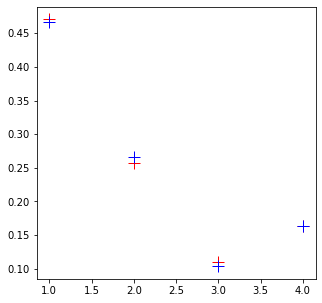

In [22]:
#this shows the fitting for frequency

results_F=metric_F(contacts,results,age_count)

plt.rcParams["figure.figsize"] = (5,5)

for i in results_F[setting].keys():
    L=list(frequency[setting].values())
    L[3]+=L[4]
    print (setting,':',i,'//','%f' % results_F[setting][i],'//','%f' % L[i-1])
    plt.plot(i,results_F[setting][i],'+r',linewidth=1, markersize=12,alpha=1)
    plt.plot(i,L[i-1],'+b',linewidth=1, markersize=12,alpha=1)
    

In [23]:
def weight_m(results,age_count) :   

    
    graph_array=results['graph_array']
    
    
    weight_m=dict()
    

    for i in rules[setting].keys():
        weight_m[i]=dict()
        for j in rules[setting][i].keys():
             weight_m[i][j]=0
    
    for i in range(N):
            for j in range(N):
                if i!=j:
                    a=age_count[nodes_dic[i]['age']]
                    b=age_count[nodes_dic[j]['age']]
                    weight_m[nodes_dic[i]['age']][nodes_dic[j]['age']]+= graph_array[i][j]/(a*b)
    
    return(weight_m)
                
    
    

In [24]:
W=weight_m(results,age_count)

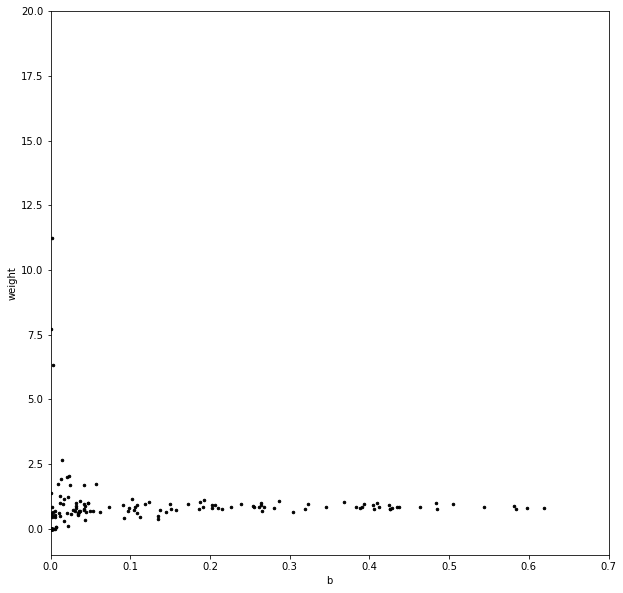

In [25]:
#this figure shows evoloution of weights thorough time
plt.rcParams["figure.figsize"] = (10,10)

for i in W.keys():
    for j in W[i].keys():
        if rules[setting][i][j] > 0:
            b=rules[setting][i][j]
            a=age_count[i]
            c=(1/rules[setting][i][j])*age_count[j]  #upper weight  
            #b=age_count[j]
            plt.plot(b,W[i][j],'k.',linewidth=.5, markersize=5,alpha=1)
            plt.plot(b,c,'r.',linewidth=.5, markersize=5,alpha=1)
        
plt.xlabel("b")
plt.ylabel('weight')
plt.axis([0,.7,-1,20])
plt.show()



In [26]:
print(end-start)

0.5974862575531006


In [27]:
sys.getsizeof(results['graph_array'])

16552